In [1]:
##################################
#                                #
# regression.ipynb               #
# Created 2023-07-26             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import pandas as pd
import numpy as np
import pickle
import os
import itertools

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
data = pd.read_excel('AMR_imputation_Dec_2023.xlsx')

In [3]:
# Only keep data prior to a change in the micro lab reporting system
data2019 = data[data['Episode'] <= 7217]

# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data2019[data2019[abx]=='no_data'].shape[0] / data2019.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data2019[(data2019['Piptaz_FINAL_imp']=='no_data')|(data2019['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data2019.shape[0]*100))

Missingness
Penicillin        2.42%
Amoxiclav        35.25%
Ampicillin        1.01%
Cloxacillin       6.52%
Piptaz            1.28%
Cefazolin         1.44%
Ceftriaxone       0.54%
Ceftazidime       0.87%
Ertapenem         1.58%
Meropenem         0.50%
Ciprofloxacin     1.31%
Levofloxacin     16.67%
Moxifloxacin      4.67%
Daptomycin        1.85%
Vancomycin        1.85%
Linezolid         1.85%
Amikacin          2.35%
Tobramycin        0.64%
Gentamicin        0.60%
Clindamycin       4.37%
Doxycycline      80.85%
Erythromycin     55.31%
TMPSMX            0.57%
Piptaz or tobra   1.38%


## Preprocessing

In [4]:
# Change missing data to be resistant
data2019[output_antibiotics] = data2019[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data2019 = data2019.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Create categorical variable columns
# Encode ages as integer variables
ages = {'<40':1, '40-45':2, '45-50':3, '50-55':4, '55-60':5, '60-65':6, 
        '65-70':7, '70-75':8, '75-80':9, '80-85':10, '85-90':11, '>90':12}
data2019['Age'] = data2019['AgeCat'].map(ages)

# Encode sex as male=0, female=1
sexes = {'M':0,'F':1}
data2019['SexCat'] = data2019['Sex'].map(sexes)
data2019

# Change community vs. hospital acquisition from 1/2 to 0/1
data2019['Community(1), Hospital(2)'] = data2019['Community(1), Hospital(2)'].replace({1:0,2:1})

# Create a column for location of acquisition: community (0), ward (1), ICU (2)
# Created by summing Comm (0) vs. Hosp (1) and ICU acquisition (0 or 1)
data2019['Acquisition'] = data2019['Community(1), Hospital(2)'] + data2019['ICU Aquired']

# Change medical vs. surgical admitting service from 1/2 to 0/1
data2019['Medical(1) Surgical (2) Admitting Service'] = data2019['Medical(1) Surgical (2) Admitting Service'].replace({1:0,2:1})
data2019 = data2019.rename({'Medical(1) Surgical (2) Admitting Service':'MedVsSurgAdmission'},axis=1)

# Encode culture type
culture_types = {'BLDC':1,'URCR':2,'BCPOS':1,'CSFCS':3,'URCC':2,
                 'FLDC':3,'BONEC':3,'BXTC' :3,'EARC':3,'FLDBC':3,
                 'FUNC':3,'GMISC':3,'DIALC':3,'INCC':3,'LRESC':3,
                 'ORCU':3,'STCS' :3,'TDRNC':3,'VTIPC':3}
data2019['CultureSource'] = data2019['culture_test_cd'].map(culture_types)

# Create new categories of "prior non-[antibiotic class]"
data2019['PriorNonCephalosporin'] = data2019[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonCarbapenem'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonPenicillin'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonFQ'] = data2019[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonAMG'] = data2019[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonOtherAbx'] = data2019[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

# Converts True/False into 1/0
data2019['PriorNonCephalosporin'] = data2019['PriorNonCephalosporin'].apply(int)
data2019['PriorNonCarbapenem']    = data2019['PriorNonCarbapenem'].apply(int)
data2019['PriorNonPenicillin']    = data2019['PriorNonPenicillin'].apply(int)
data2019['PriorNonFQ']            = data2019['PriorNonFQ'].apply(int)
data2019['PriorNonAMG']           = data2019['PriorNonAMG'].apply(int)
data2019['PriorNonOtherAbx']      = data2019['PriorNonOtherAbx'].apply(int)

data2019 = data2019.drop(['MRSA12months','VRE12months','ESBL12months','MRSA7days','VRE7days','ESBL7days',
                          'NumberOfBacteremiasLastYear','ClincalMRSA','ClinicalVRE'],axis=1,errors='ignore')
data2019

,Anonymous_ID,Episode,AgeCat,Sex,YearOfAdmission,"Community(1), Hospital(2)",ICU Aquired,MedVsSurgAdmission,ClincalMRAS,ClinicalESBL,...,Age,SexCat,Acquisition,CultureSource,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorNonAMG,PriorNonOtherAbx
0,1,1,85-90,M,2008,1,0,0,0,0,...,11,0,1,2,1,1,0,1,1,1
1,1,2,85-90,M,2008,1,0,0,0,0,...,11,0,1,2,1,1,1,1,1,1
2,2,9,>90,M,2011,1,0,0,0,0,...,12,0,1,2,0,0,0,0,0,0
3,3,15,>90,M,2012,1,0,0,0,0,...,12,0,1,2,0,0,0,0,0,0
4,4,25,45-50,F,2013,1,0,0,0,0,...,3,1,1,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2313,7212,60-65,M,2019,0,0,0,0,0,...,6,0,0,2,0,0,0,0,0,0
2972,2314,7215,75-80,M,2019,1,0,0,0,0,...,9,0,1,1,0,0,0,0,0,0
2973,2314,7215,75-80,M,2019,1,0,0,0,0,...,9,0,1,2,0,0,0,0,0,0
2974,2314,7216,75-80,M,2019,1,1,0,0,0,...,9,0,2,1,1,1,1,1,1,1


In [5]:
# List of antibiotics to run regression on
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']
antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx'}

In [6]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous susceptible gram negative organism
        1 if previous resistant gram negative organism
        1 if previous gram negative organism without susceptibility data
    '''
    
    if priorGNOrg=='not_applicable': return 0
    elif prior_susceptibility=='no_data': 
        return 1
    else: return prior_susceptibility

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    data2019['Prior'+antibiotic+'Resistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
data2019['Piptaz_or_Tobramycin_FINAL_imp'] = (data2019['Piptaz_FINAL_imp'])*(data2019['Tobramycin_FINAL_imp'])
antibiotic_list.append('Piptaz_or_Tobramycin')

# Add a column for hospital site 
# 0 = Sunnybrook, 1 = Ottawa
data2019['Hospital'] = 0

In [7]:
data2019['FINAL'].value_counts()

FINAL
Escherichia coli                                 1409
Klebsiella pneumoniae                             450
Pseudomonas aeruginosa                            423
Enterobacter cloacae                              141
Proteus mirabilis                                 132
Serratia marcescens                                64
Enterobacter aerogenes                             61
Klebsiella oxytoca                                 59
Citrobacter koseri                                 57
Citrobacter freundii                               37
Morganella morganii                                25
Stenotrophomonas maltophilia                       22
Acinetobacter baumannii                            14
Haemophilus influenzae                             12
Proteus penneri                                     8
Providencia stuartii                                7
Raoultella                                          7
Klebsiella species                                  5
Providencia rettgeri  

# Regression Function

In [8]:
regression_inputs = ['Hospital','Age','SexCat','MedVsSurgAdmission',
                     'RecentHospitalization','ICUExposure','Acquisition',
                     
                     'PriorPenicillin','PriorCephalosporin','PriorCarbapenem',
                     'PriorFQ','PriorAMG','PriorOtherAbx',                     
                     'PriorCefazolinResistance', 'PriorCeftriaxoneResistance', 
                     'PriorCeftazidimeResistance', 'PriorPiptazResistance', 
                     'PriorMeropenemResistance', 'PriorCiprofloxacinResistance', 
                     'PriorTobramycinResistance', 'PriorTMPSMXResistance',
                     'ClinicalESBL']

print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 22



Logistic regression model for Cefazolin:

Logistic Regression Coefficients
ClinicalESBL                                1.1093
PriorPiptazResistance                       1.1016
PriorCeftriaxoneResistance                  1.1016
PriorCephalosporin                          0.5764
PriorTobramycinResistance                   0.4150
Acquisition                                 0.3433
PriorCiprofloxacinResistance                0.3018
MedVsSurgAdmission                          0.2544
PriorOtherAbx                               0.2224
PriorMeropenemResistance                    0.1616
PriorCarbapenem                             0.1108
PriorFQ                                     0.0464
ICUExposure                                 0.0350
PriorAMG                                    0.0075
PriorCeftazidimeResistance                  0.0017
Hospital                                    0.0000
RecentHospitalization                      -0.0241
PriorPenicillin                            -0.0468
Age   

C:\Users\notqu\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


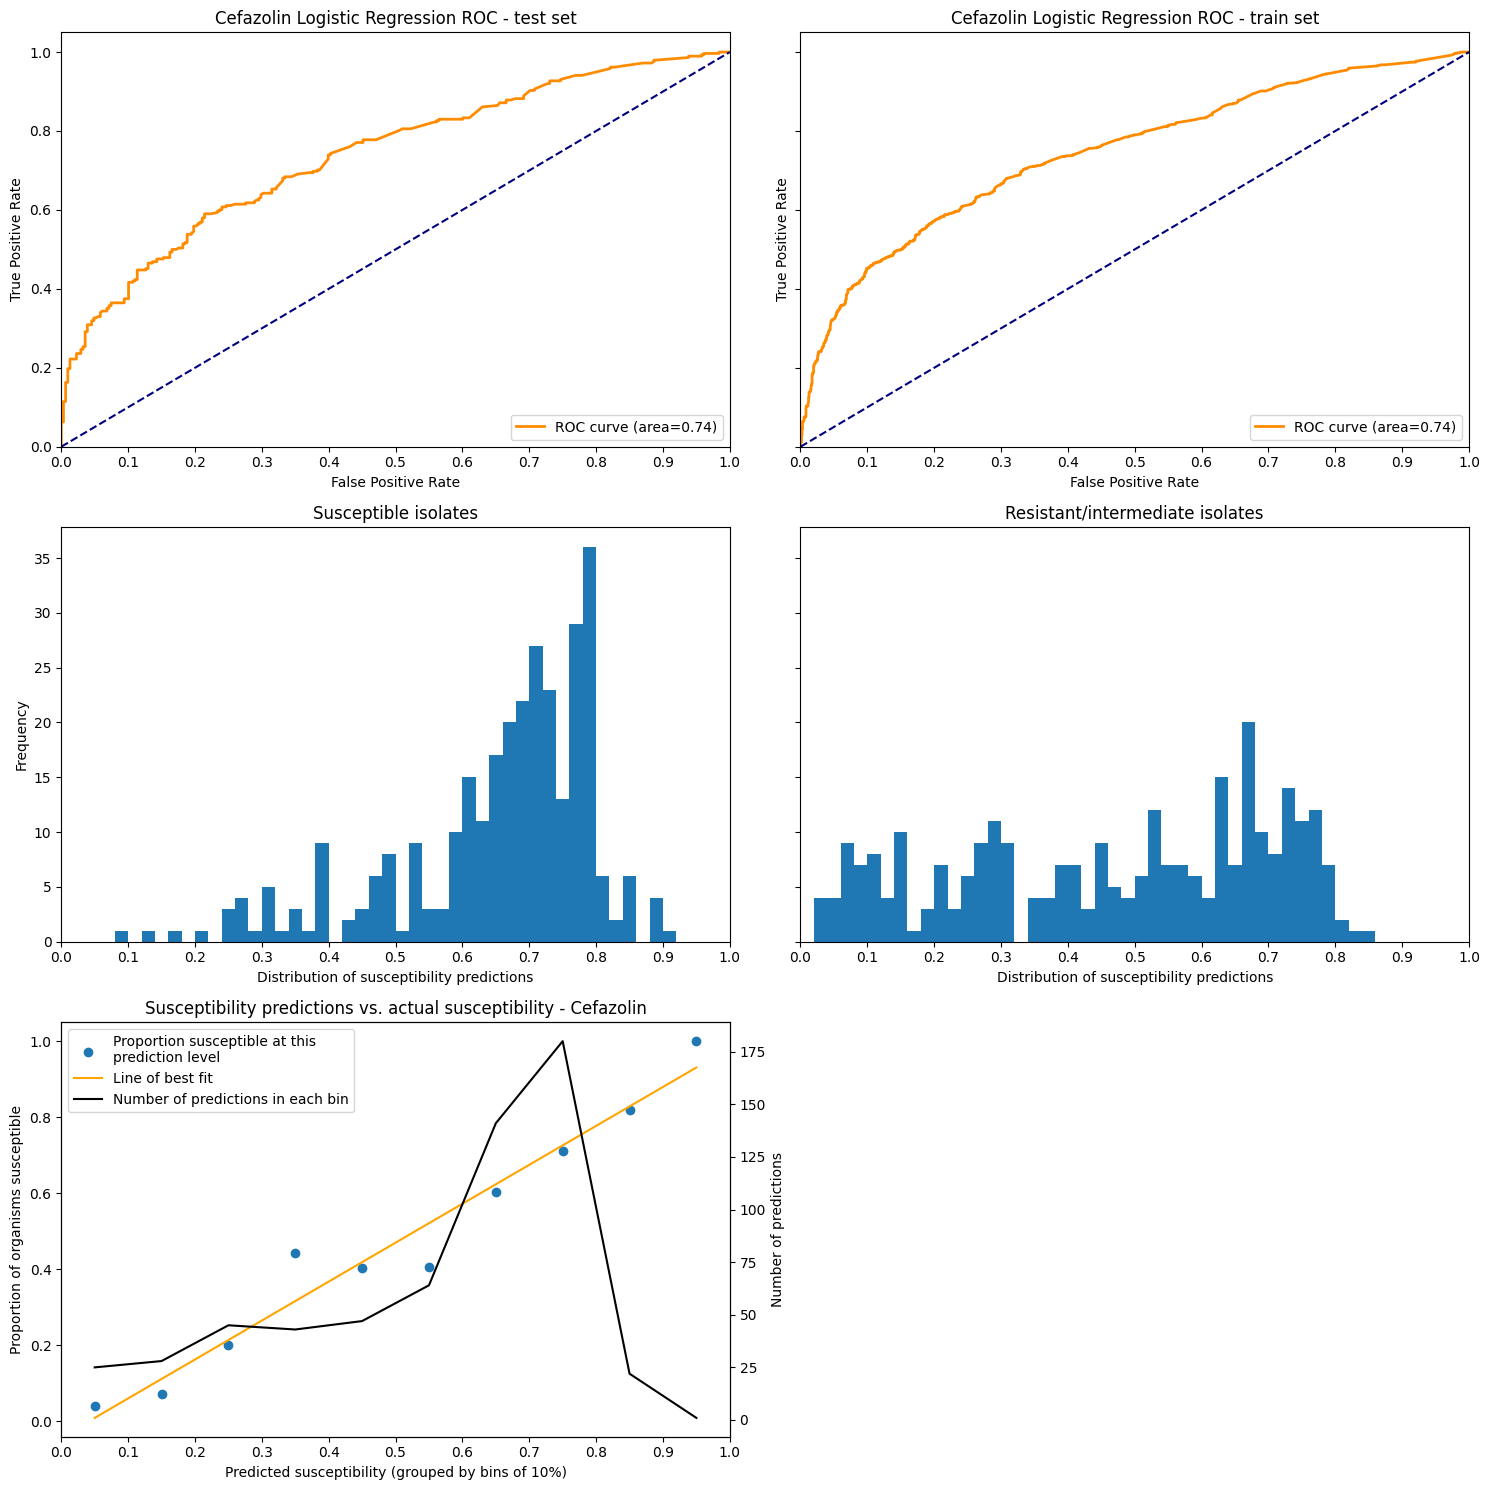


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
ClinicalESBL                                1.5355
PriorMeropenemResistance                    1.2910
PriorCephalosporin                          0.5947
PriorCiprofloxacinResistance                0.4440
PriorPiptazResistance                       0.3723
PriorCeftriaxoneResistance                  0.3723
Acquisition                                 0.3191
PriorAMG                                    0.2640
PriorOtherAbx                               0.2627
PriorTobramycinResistance                   0.2134
PriorCeftazidimeResistance                  0.1941
MedVsSurgAdmission                          0.0874
RecentHospitalization                       0.0134
Hospital                                    0.0000
PriorTMPSMXResistance                      -0.0110
PriorCarbapenem                            -0.0153
PriorPenicillin                            -0.0431
Age                                        -0.0613
Prio

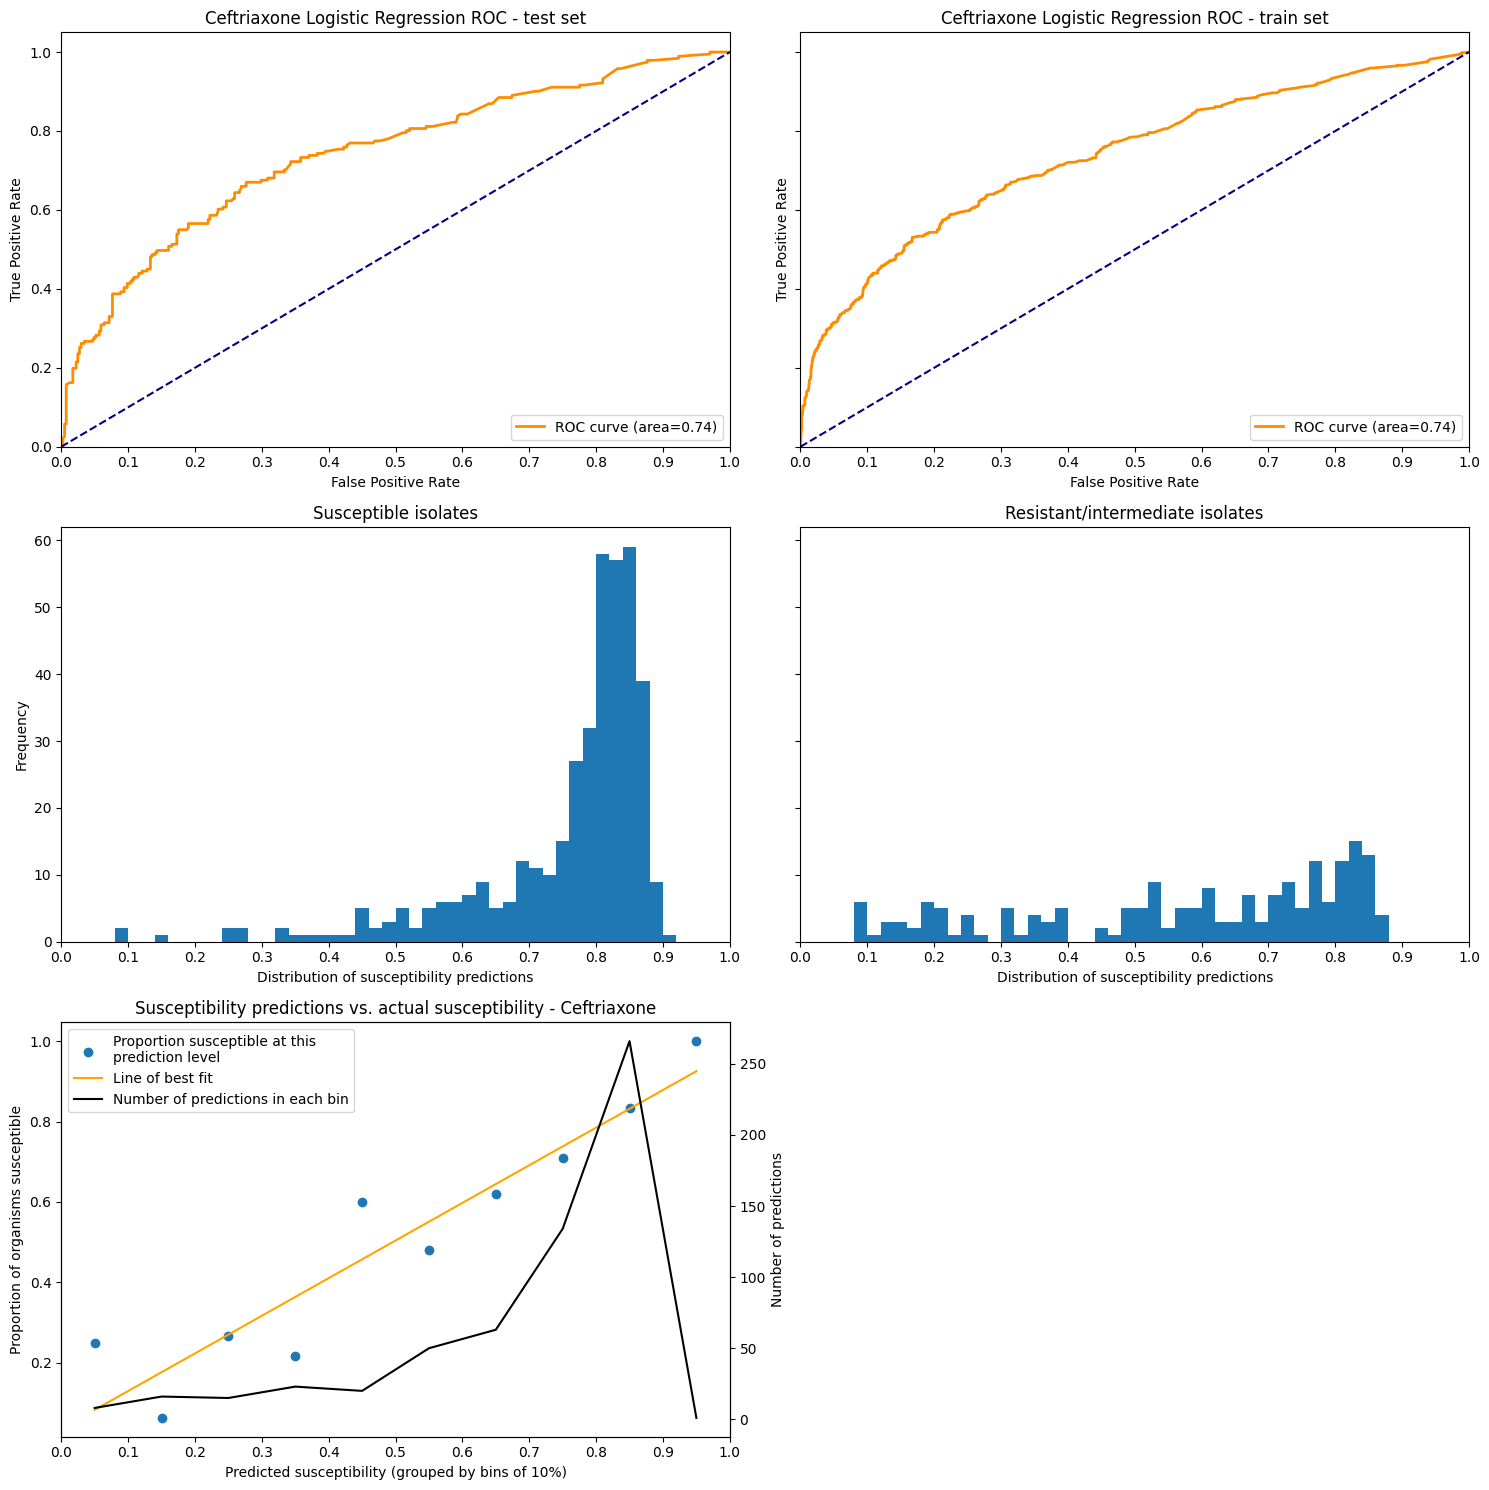


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
ClinicalESBL                                1.6813
PriorAMG                                    0.9037
PriorTobramycinResistance                   0.5773
PriorMeropenemResistance                    0.4530
PriorCeftazidimeResistance                  0.4149
PriorPiptazResistance                       0.3732
PriorCeftriaxoneResistance                  0.3732
PriorCiprofloxacinResistance                0.3383
PriorOtherAbx                               0.3228
PriorCephalosporin                          0.3147
Acquisition                                 0.1477
MedVsSurgAdmission                          0.1403
SexCat                                      0.1038
RecentHospitalization                       0.0735
Hospital                                    0.0000
PriorFQ                                    -0.0144
Age                                        -0.0430
PriorPenicillin                            -0.0454
Prio

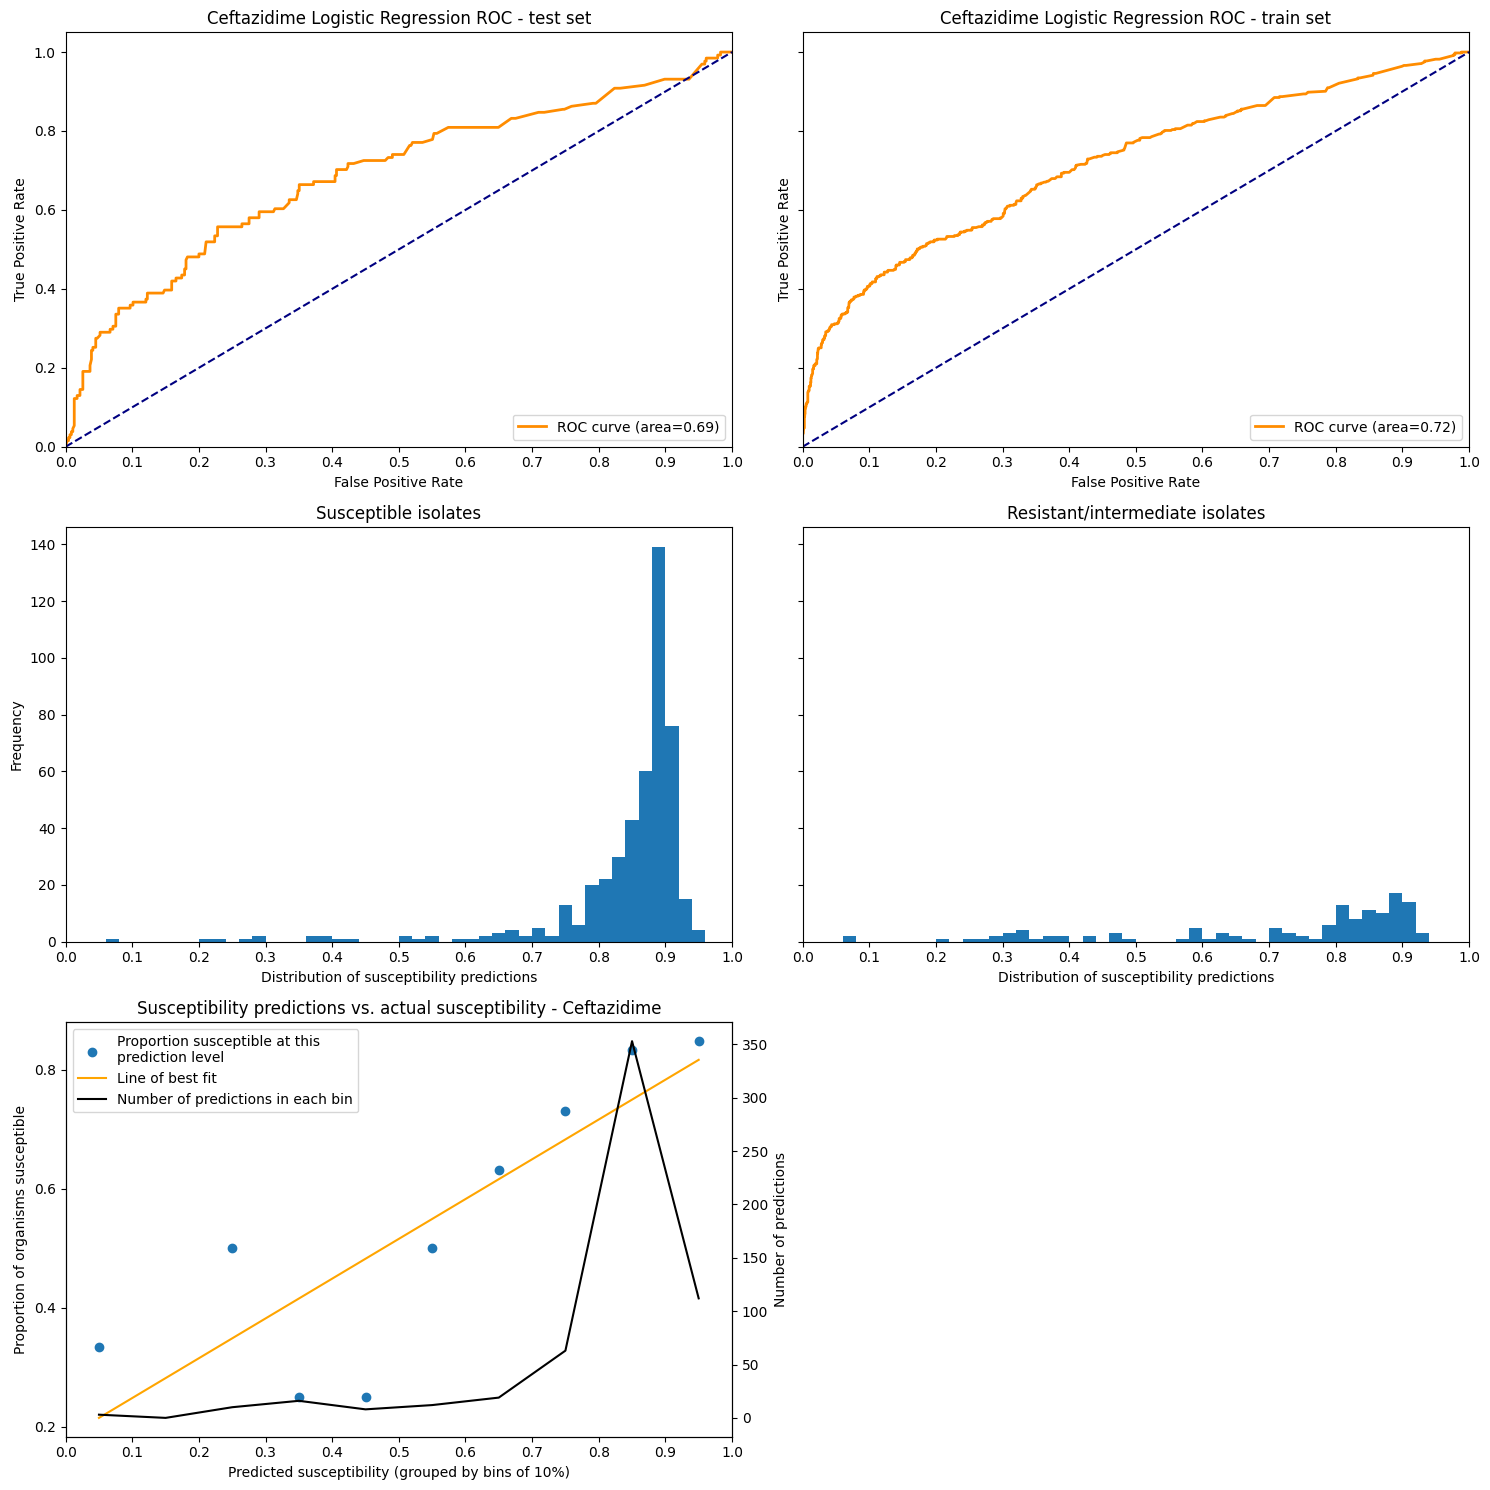


Logistic regression model for Piptaz:

Logistic Regression Coefficients
ClinicalESBL                                1.3093
PriorPiptazResistance                       0.5448
PriorCeftriaxoneResistance                  0.5448
PriorCiprofloxacinResistance                0.5313
PriorTobramycinResistance                   0.4538
PriorMeropenemResistance                    0.4418
PriorAMG                                    0.3350
PriorOtherAbx                               0.3134
PriorCephalosporin                          0.2901
PriorPenicillin                             0.2268
MedVsSurgAdmission                          0.1814
PriorCarbapenem                             0.1474
Acquisition                                 0.0679
PriorFQ                                     0.0104
Hospital                                    0.0000
SexCat                                     -0.0075
Age                                        -0.0483
PriorTMPSMXResistance                      -0.0812
RecentHos

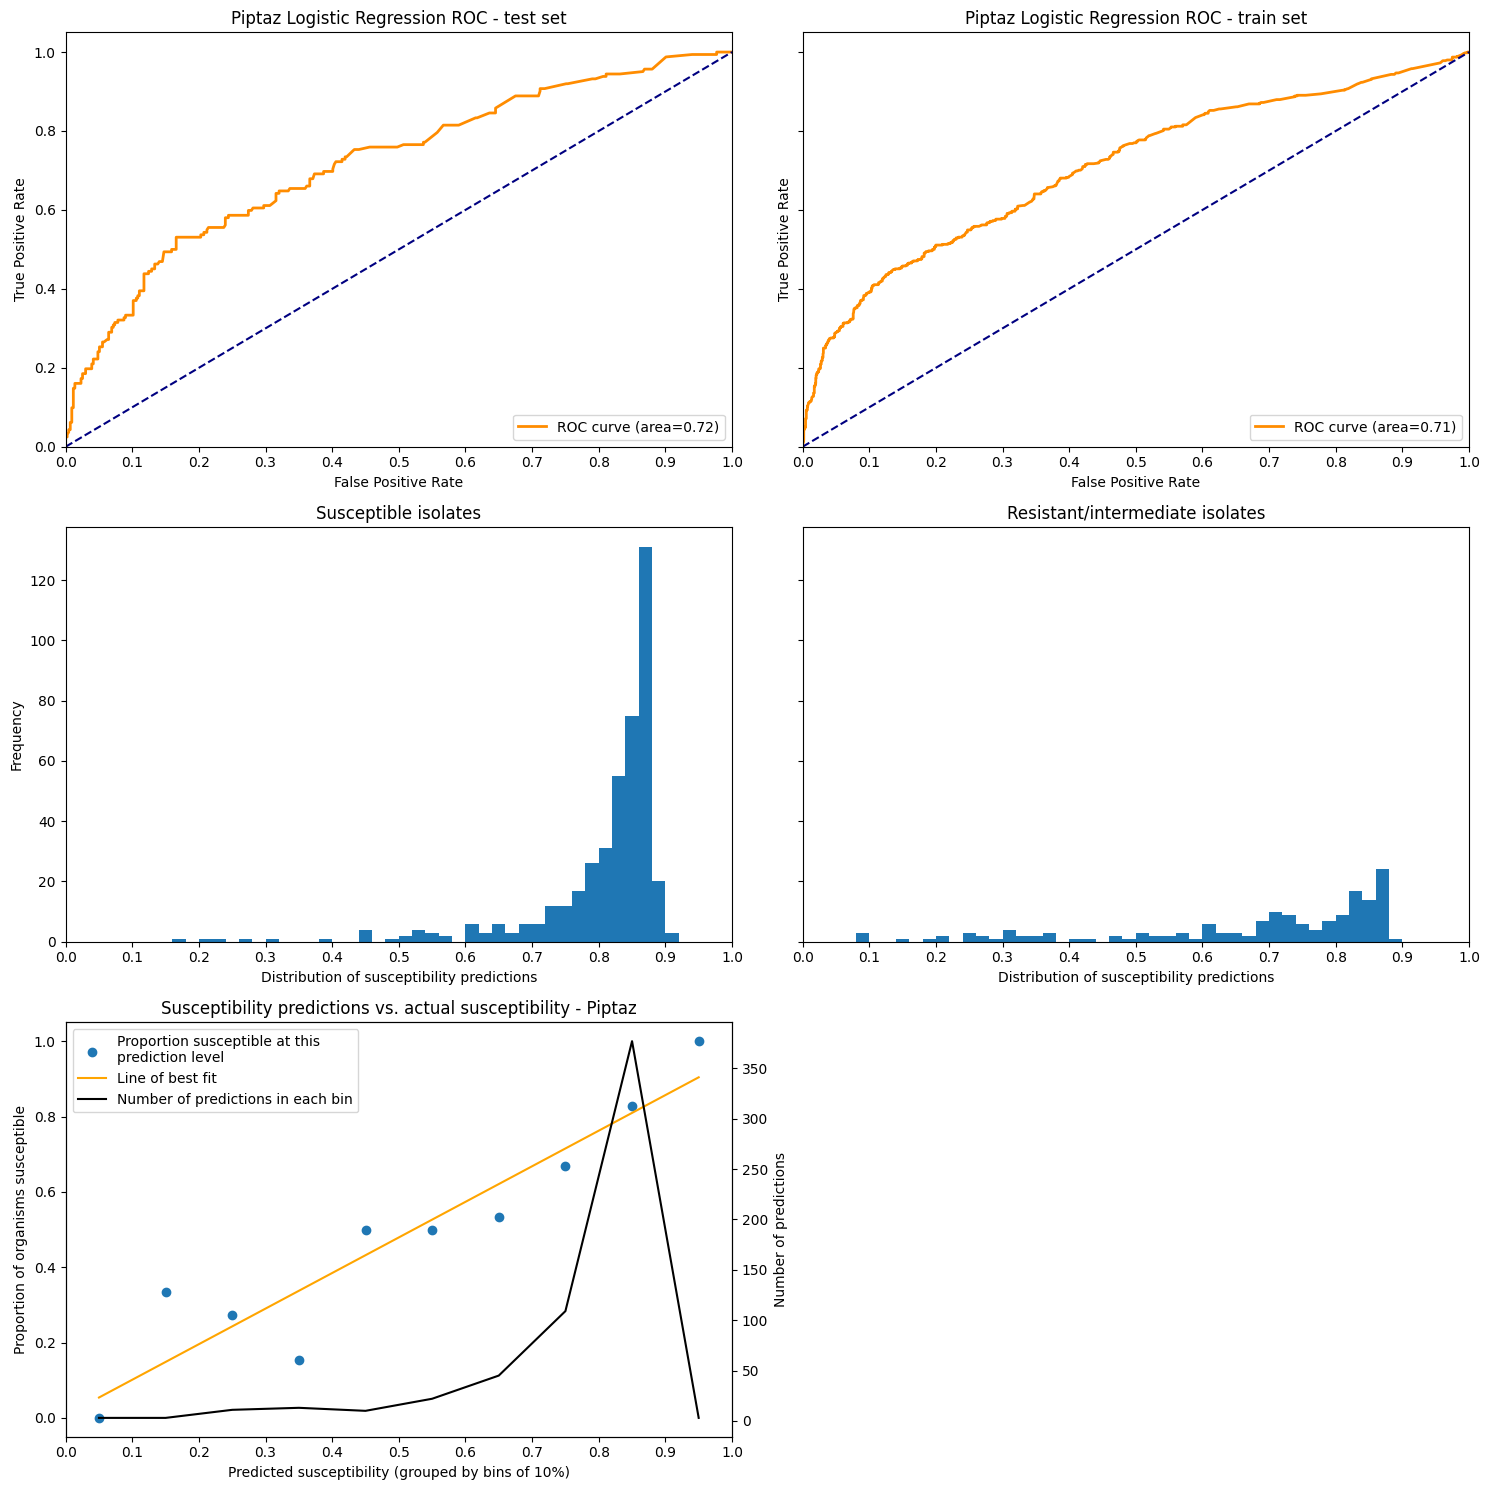


Logistic regression model for Meropenem:

Logistic Regression Coefficients
PriorCarbapenem                             1.1925
PriorAMG                                    1.1545
PriorMeropenemResistance                    0.7764
PriorCiprofloxacinResistance                0.7670
PriorPiptazResistance                       0.5274
PriorCeftriaxoneResistance                  0.5274
PriorTMPSMXResistance                       0.4317
PriorCeftazidimeResistance                  0.4263
PriorOtherAbx                               0.2652
Acquisition                                 0.1456
PriorPenicillin                             0.0821
PriorFQ                                     0.0633
Hospital                                    0.0000
ICUExposure                                -0.0553
Age                                        -0.1598
PriorCephalosporin                         -0.2319
ClinicalESBL                               -0.2707
SexCat                                     -0.2985
MedVsS

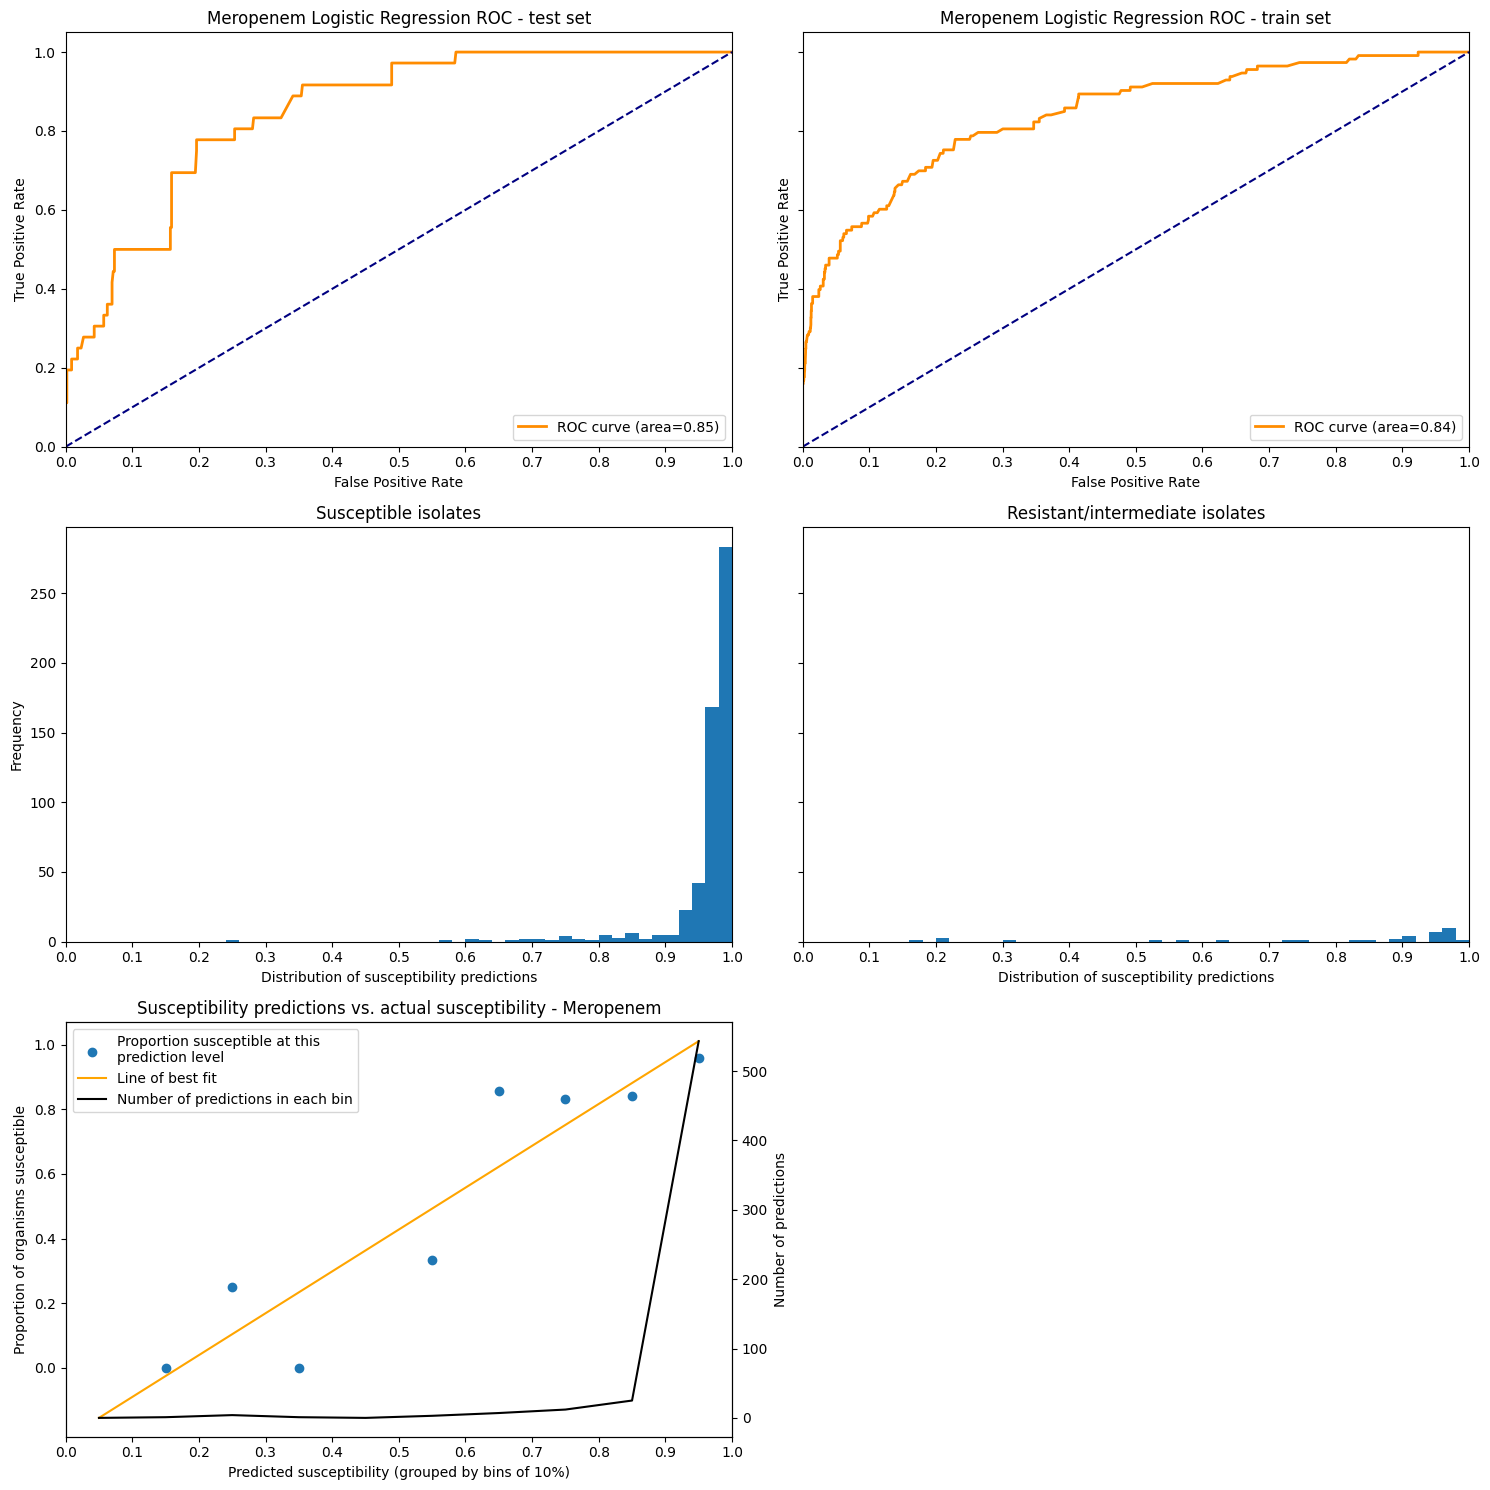


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
PriorCiprofloxacinResistance                1.8378
PriorFQ                                     1.0162
ClinicalESBL                                1.0063
PriorAMG                                    0.4422
PriorPiptazResistance                       0.1910
PriorCeftriaxoneResistance                  0.1910
PriorMeropenemResistance                    0.0928
PriorOtherAbx                               0.0209
Acquisition                                 0.0099
Hospital                                    0.0000
Age                                        -0.0182
PriorTMPSMXResistance                      -0.0516
RecentHospitalization                      -0.0533
PriorTobramycinResistance                  -0.1424
PriorCeftazidimeResistance                 -0.1505
MedVsSurgAdmission                         -0.1577
PriorCarbapenem                            -0.1643
PriorCephalosporin                         -0.1745
Pr

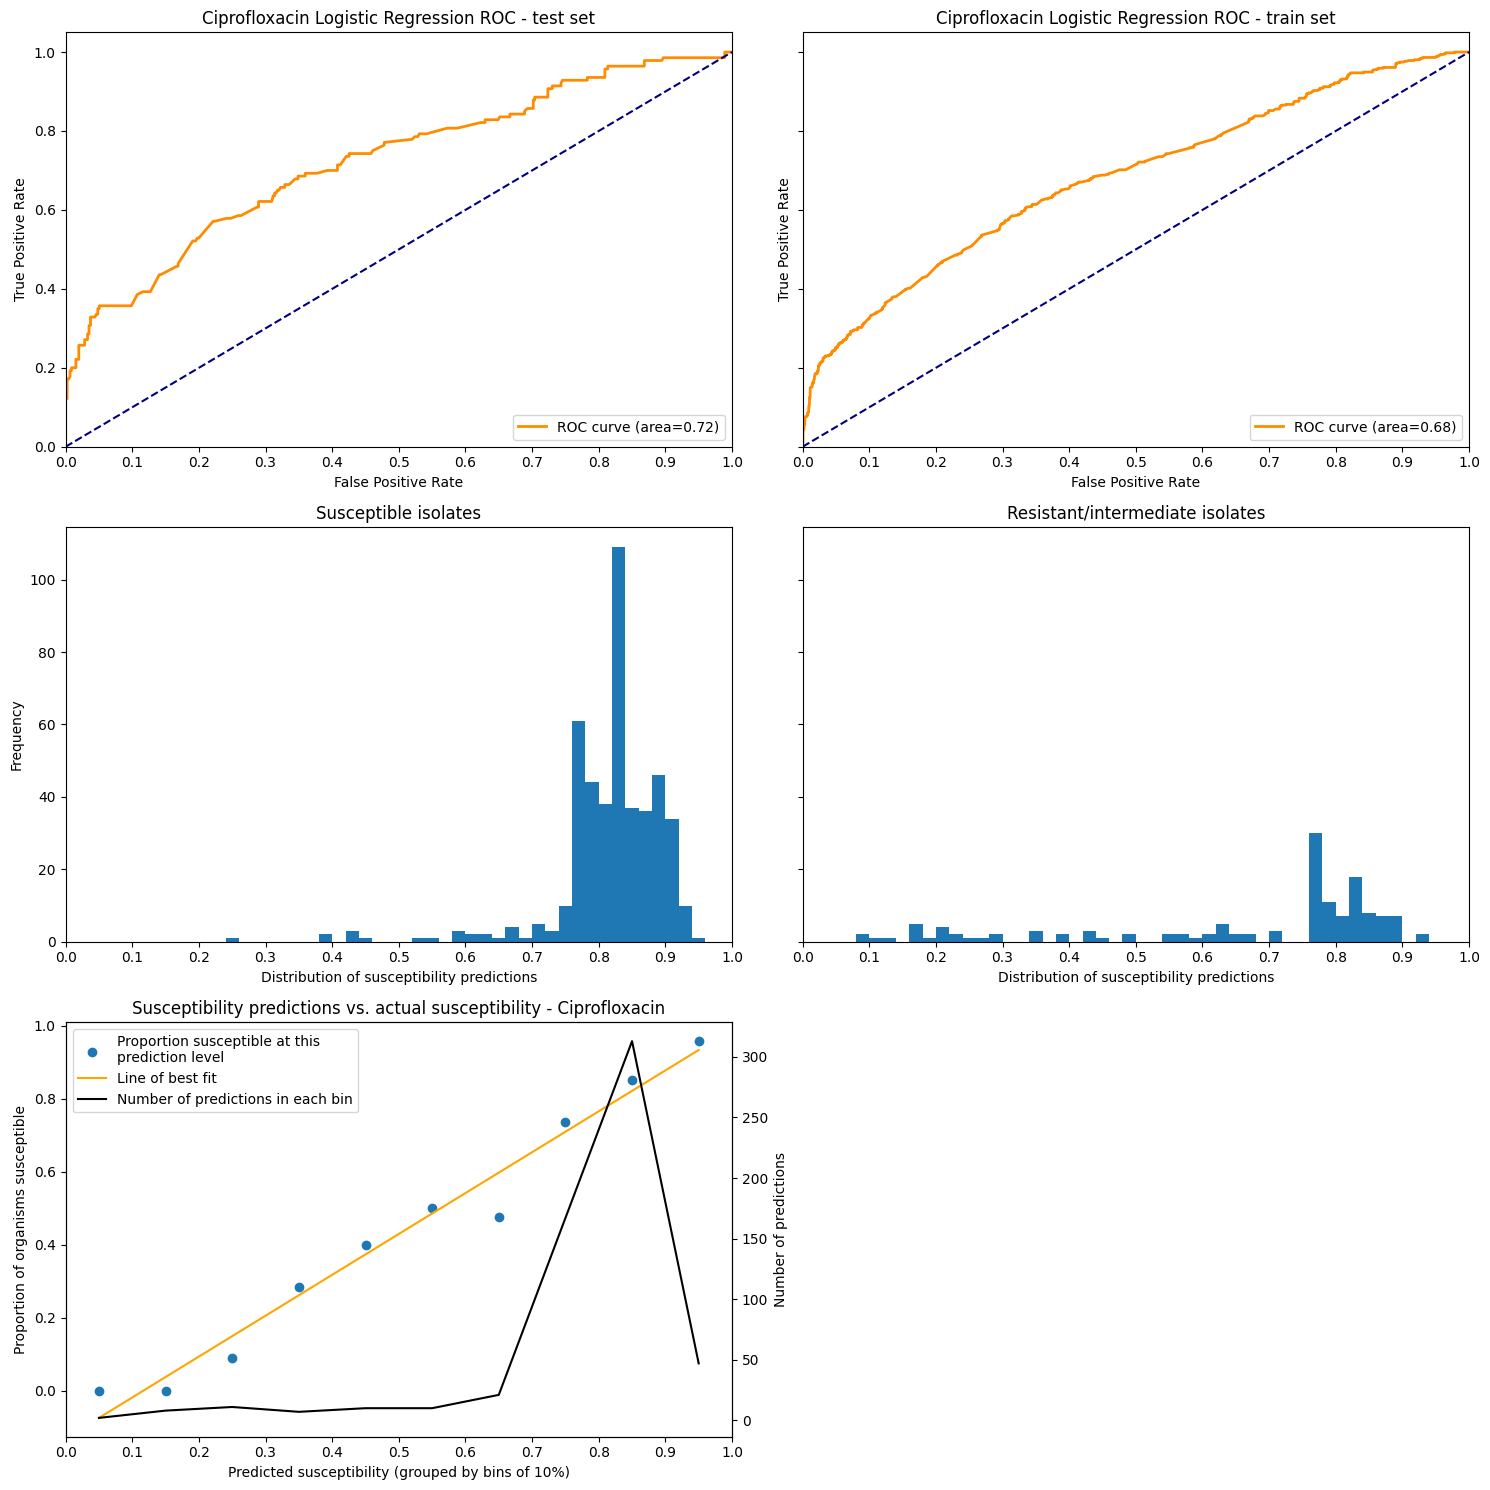


Logistic regression model for Tobramycin:

Logistic Regression Coefficients
PriorTobramycinResistance                   2.5129
PriorAMG                                    0.6282
PriorCeftazidimeResistance                  0.6056
ClinicalESBL                                0.4792
PriorFQ                                     0.2799
RecentHospitalization                       0.1931
PriorPiptazResistance                       0.1105
PriorCeftriaxoneResistance                  0.1105
PriorOtherAbx                               0.1019
Acquisition                                 0.0398
Hospital                                    0.0000
Age                                        -0.0070
PriorTMPSMXResistance                      -0.0124
PriorCephalosporin                         -0.0207
PriorCarbapenem                            -0.0208
ICUExposure                                -0.0567
PriorPenicillin                            -0.3027
MedVsSurgAdmission                         -0.3035
Prior

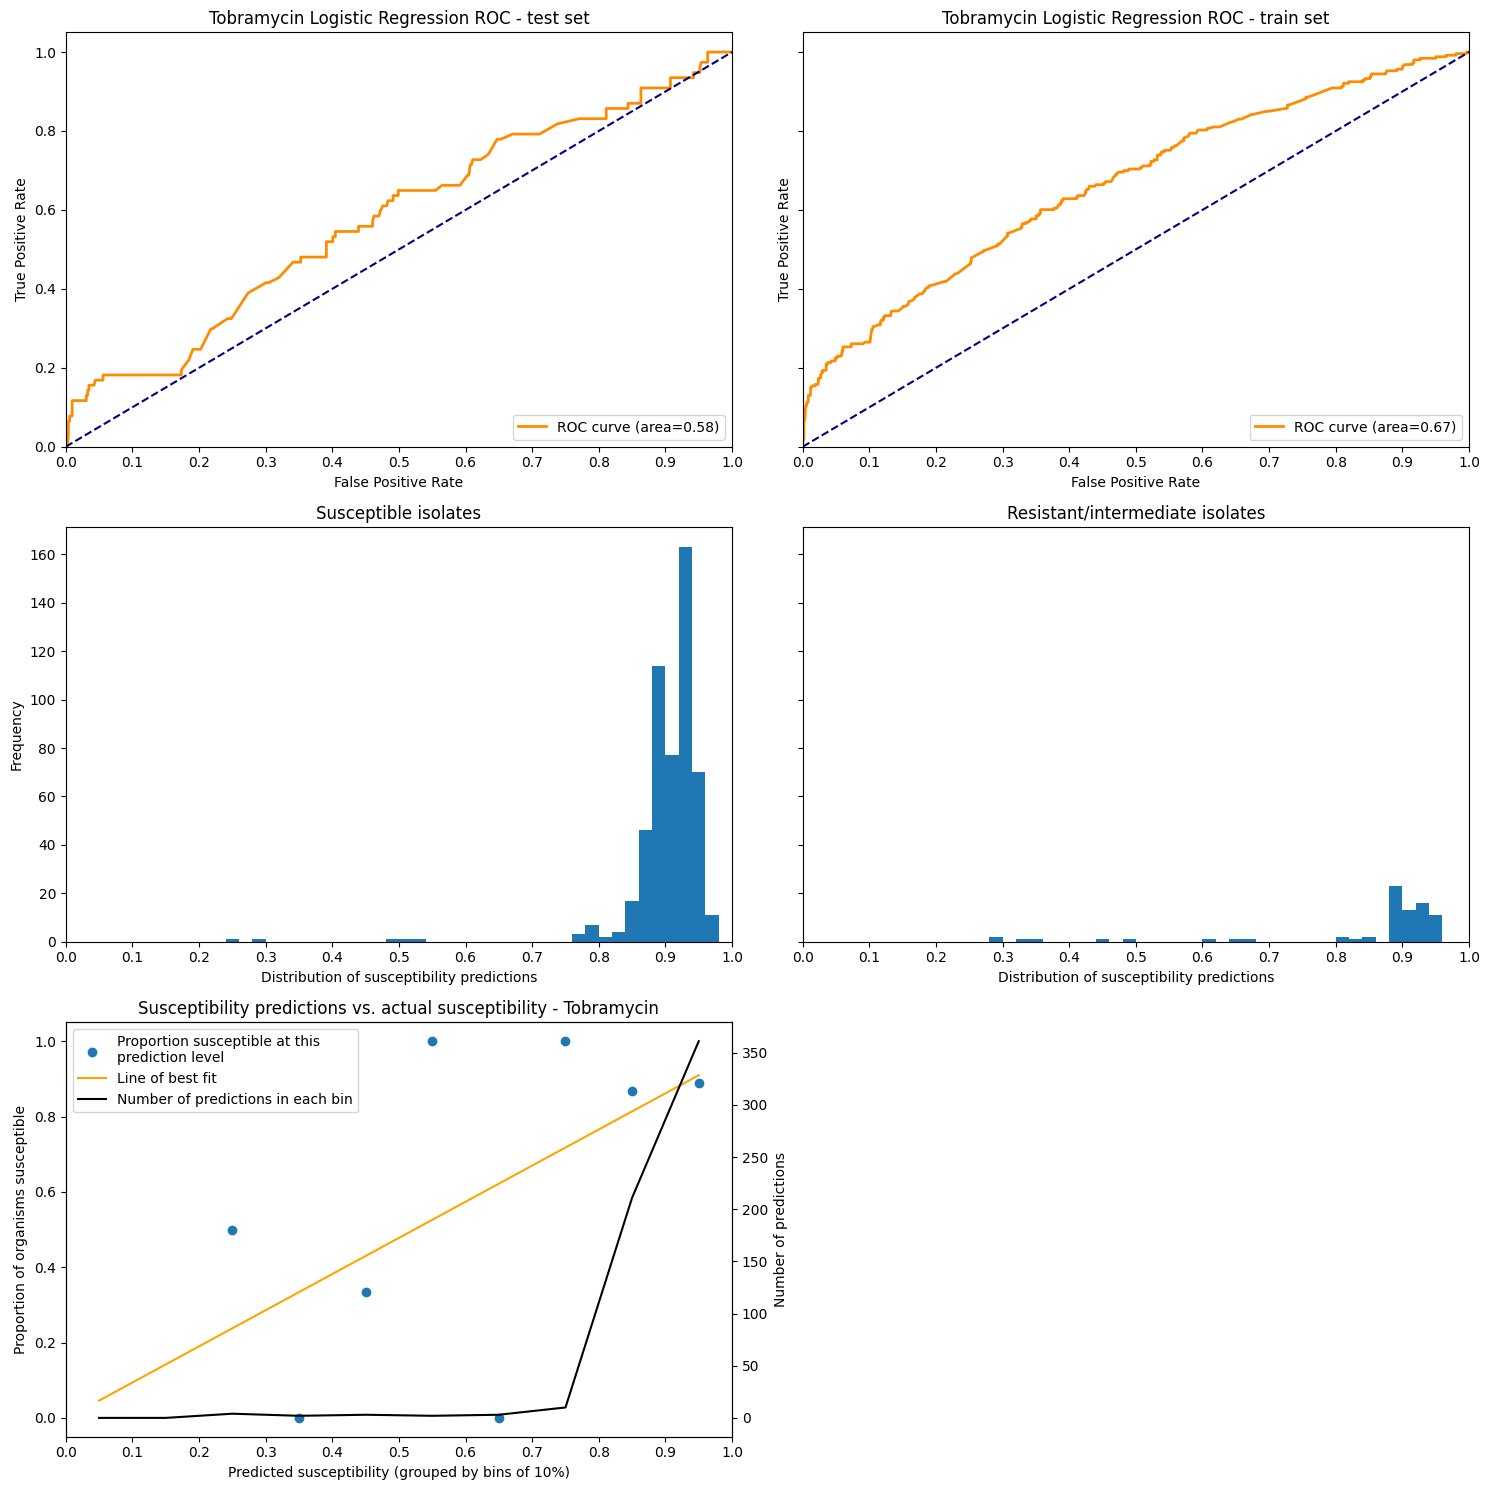


Logistic regression model for TMPSMX:

Logistic Regression Coefficients
PriorTMPSMXResistance                       1.9351
PriorMeropenemResistance                    0.7592
ClinicalESBL                                0.7590
PriorTobramycinResistance                   0.5176
PriorOtherAbx                               0.2357
PriorCephalosporin                          0.2067
MedVsSurgAdmission                          0.1830
PriorFQ                                     0.1614
PriorCiprofloxacinResistance                0.0960
Acquisition                                 0.0863
Hospital                                    0.0000
PriorCarbapenem                            -0.0097
PriorCeftazidimeResistance                 -0.0135
RecentHospitalization                      -0.0276
PriorAMG                                   -0.0454
Age                                        -0.0622
PriorPiptazResistance                      -0.0825
PriorCeftriaxoneResistance                 -0.0825
SexCat   

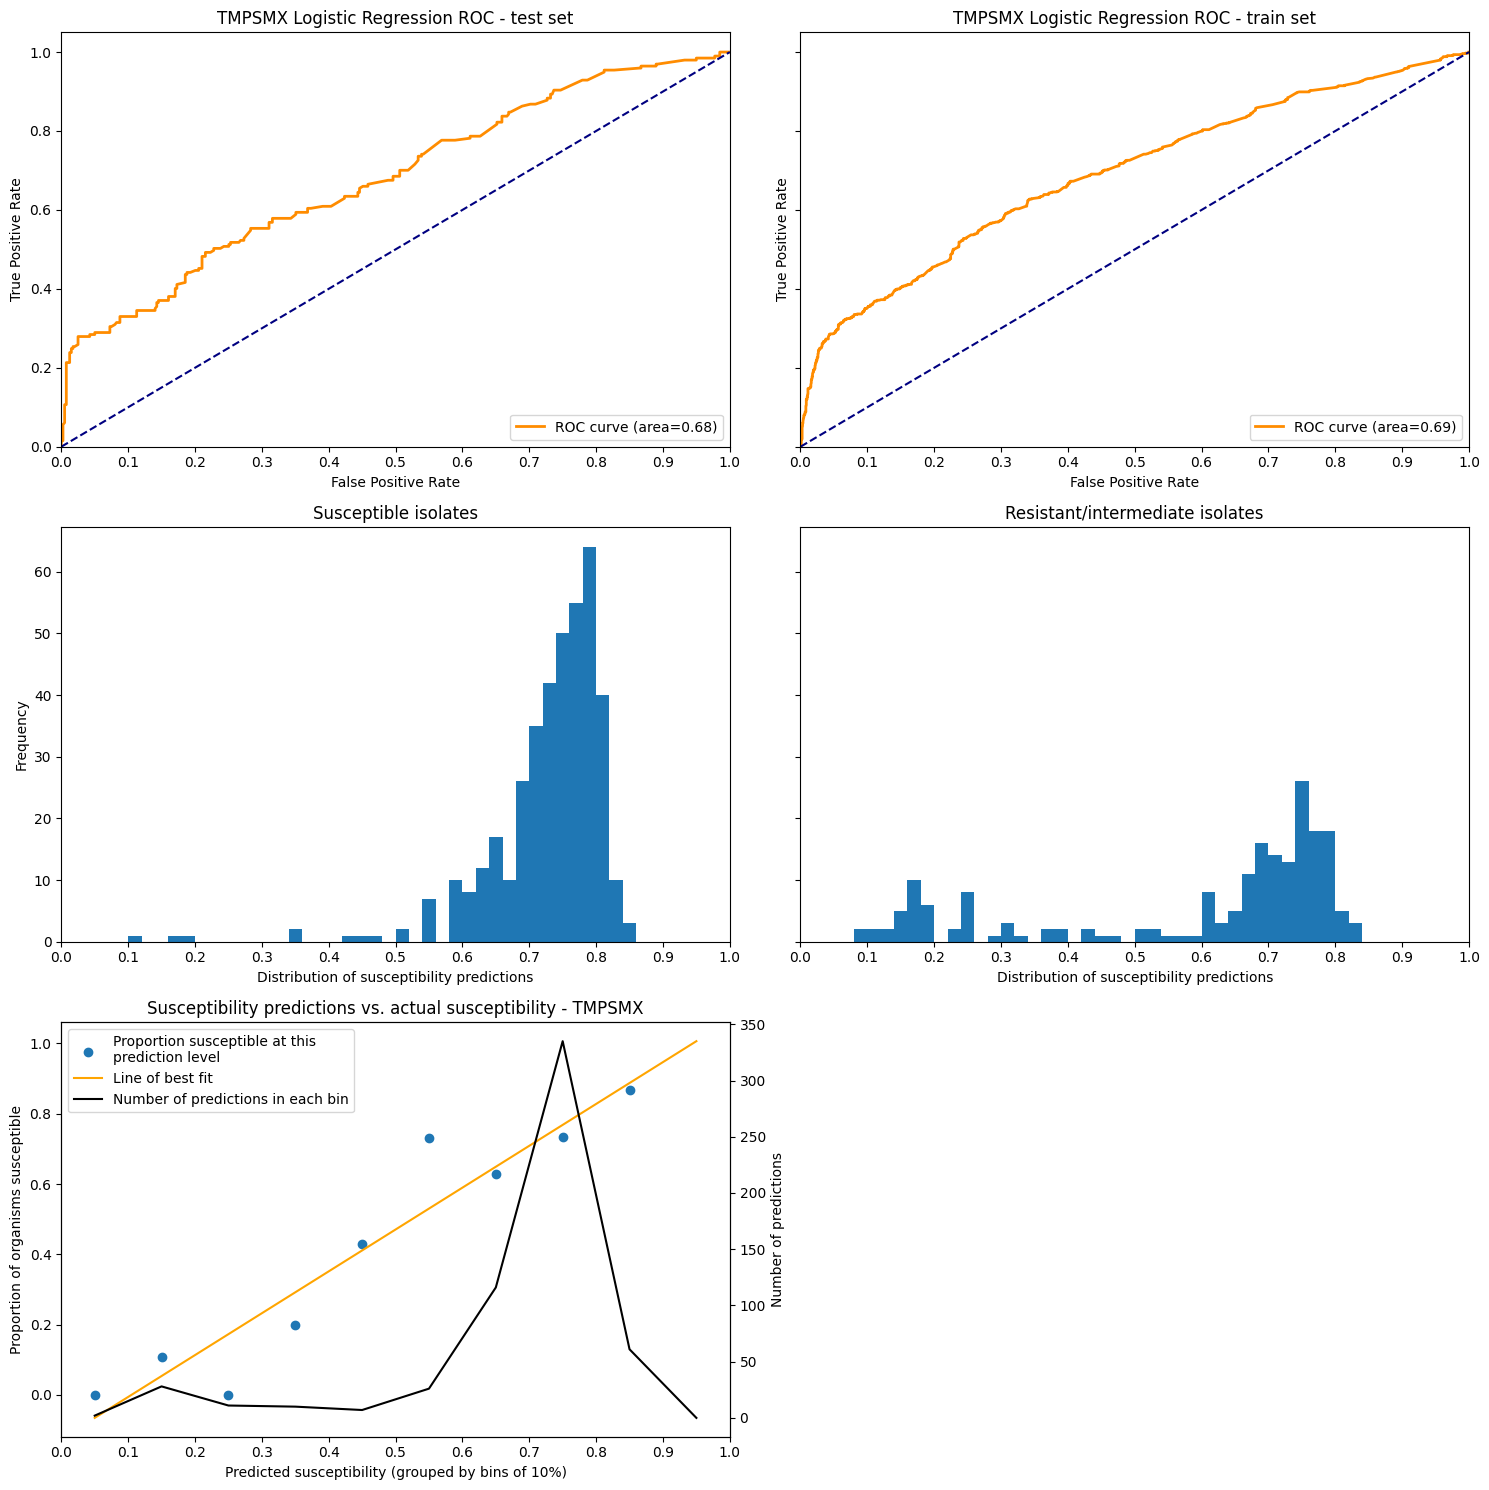


Logistic regression model for Piptaz_or_Tobramycin:

Logistic Regression Coefficients
PriorTobramycinResistance                   1.8867
ClinicalESBL                                0.6843
PriorPiptazResistance                       0.5077
PriorCeftriaxoneResistance                  0.5077
RecentHospitalization                       0.2999
PriorFQ                                     0.2846
PriorCarbapenem                             0.2170
Acquisition                                 0.1620
PriorCeftazidimeResistance                  0.1249
PriorAMG                                    0.0938
PriorOtherAbx                               0.0141
Hospital                                    0.0000
PriorCephalosporin                         -0.0072
PriorPenicillin                            -0.0414
Age                                        -0.0558
PriorCiprofloxacinResistance               -0.1388
ICUExposure                                -0.1572
MedVsSurgAdmission                         -0.

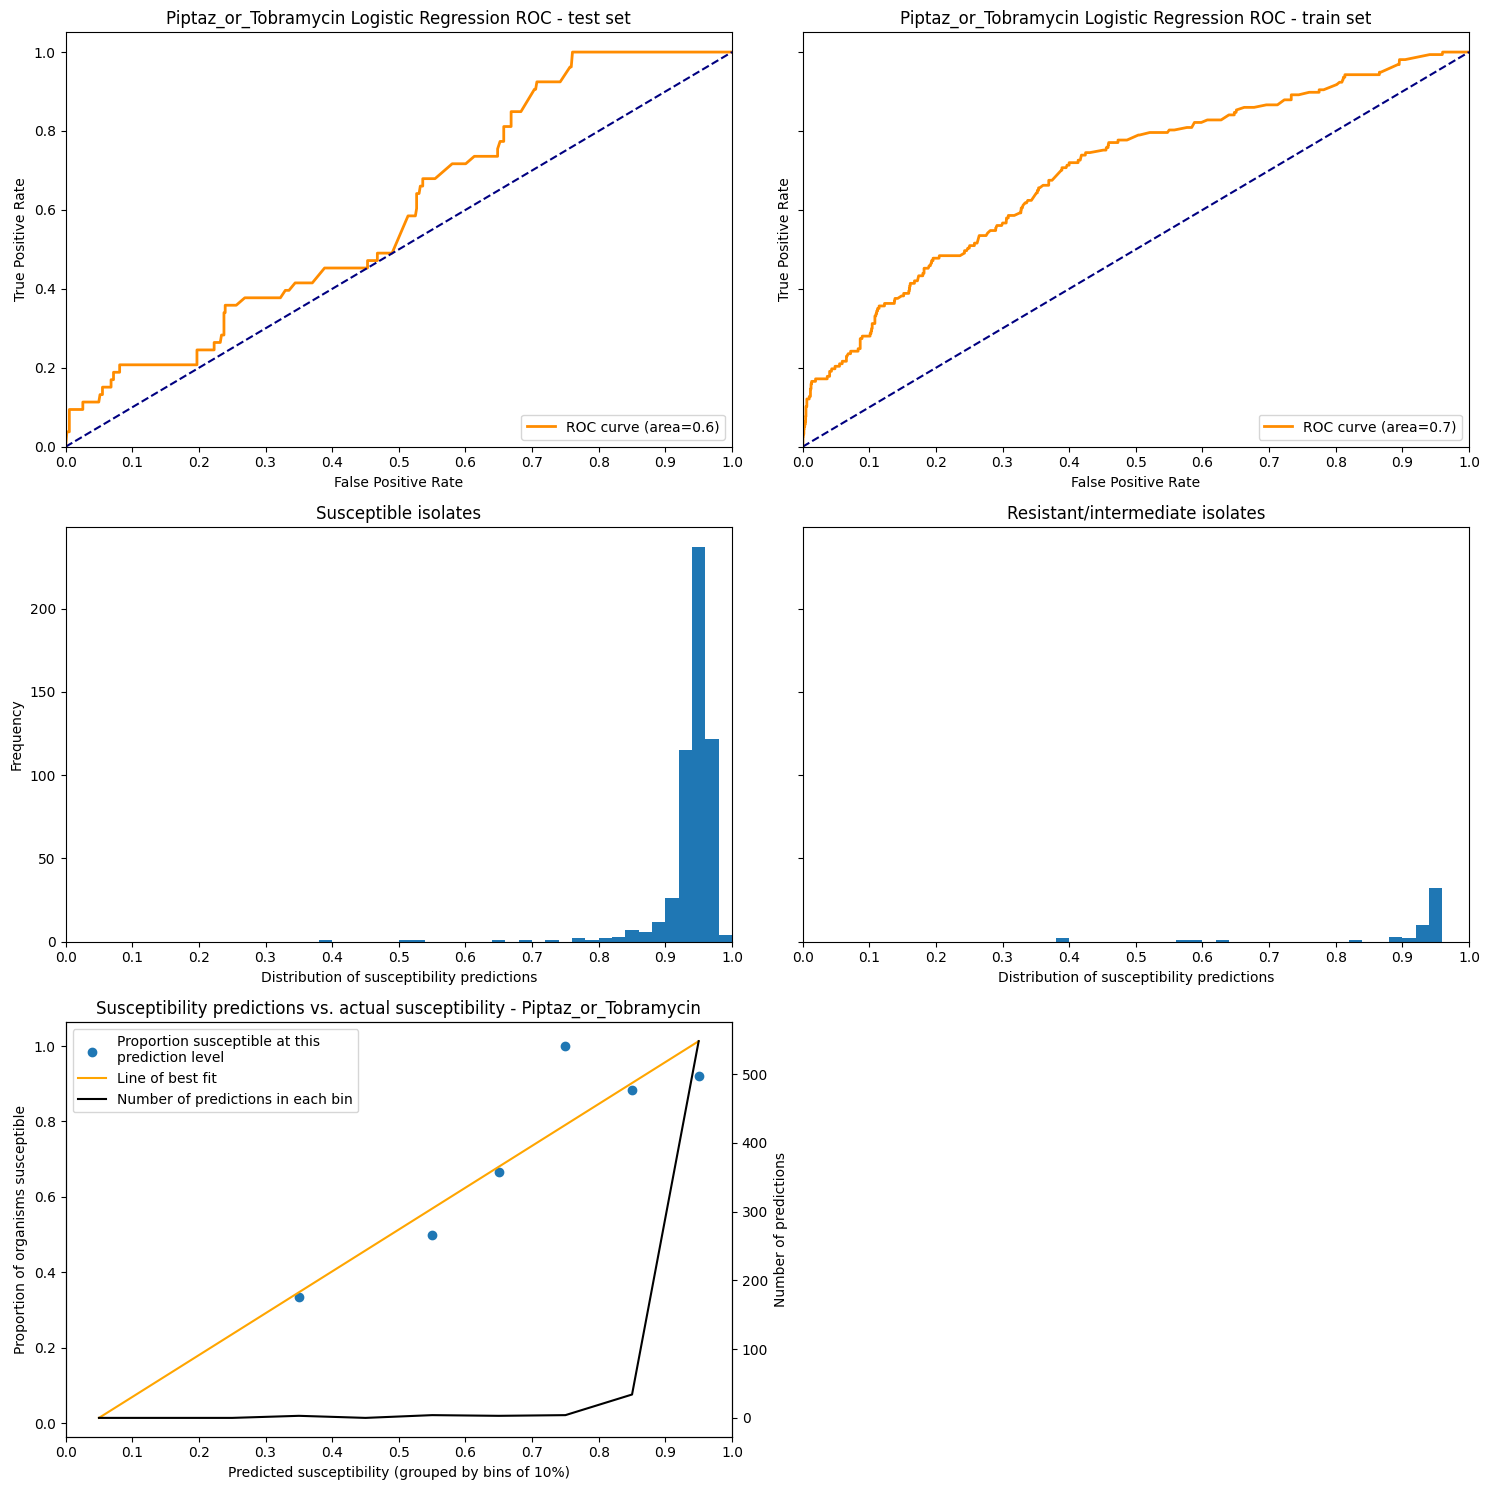

In [9]:
# Divide data into temporal 80-20 train-test sets
train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']

    reg = linear_model.LogisticRegression(max_iter=200)
    reg.fit(X_train,Y_train)
    
    # Save the regression model to pickle
    with open(antibiotic+'.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)
        
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))

    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            

    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates,
             bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates,
             bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    


    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

## Mean predicted susceptibility of each antibiotic

In [10]:
print('Mean predicted susceptibility of each analyzed antibiotic\n')
print('{:<20} {:<7} {:<7}'.format('Antibiotic','Prob S','Actual S'))

for antibiotic in antibiotic_list:
        
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']

    reg = linear_model.LogisticRegression(max_iter=200)
    reg.fit(X_train,Y_train)
    
    # print(antibiotic, 1-np.mean(Y_test))
    print('{:<20} {:>6.2f} {:>9.2f}'.format(antibiotic, 
                                            np.mean(reg.predict_proba(X_test)[:,0]),
                                            1-np.mean(Y_test)))

Mean predicted susceptibility of each analyzed antibiotic

Antibiotic           Prob S  Actual S
Cefazolin              0.57      0.52
Ceftriaxone            0.70      0.68
Ceftazidime            0.82      0.78
Piptaz                 0.77      0.73
Meropenem              0.95      0.94
Ciprofloxacin          0.78      0.77
Tobramycin             0.90      0.87
TMPSMX                 0.68      0.67
Piptaz_or_Tobramycin   0.93      0.91


In [11]:
# List of allowed regression inputs
input_values = {'Hospital':[0,1],
                'Age':list(range(1,13)),
                'SexCat':[0,1],
                'MedVsSurgAdmission':[0,1],
                'RecentHospitalization':[0,1],
                'ICUExposure':[0,1],                
                'Acquisition':[0,1],                
                'PriorPenicillin':[0,1],
                'PriorCephalosporin':[0,1],
                'PriorCarbapenem':[0,1],
                'PriorFQ':[0,1],
                'PriorAMG':[0,1],
                'PriorOtherAbx':[0,1],
                'PriorCefazolinResistance':[0,1],
                'PriorCeftriaxoneResistance':[0,1],
                'PriorCeftazidimeResistance':[0,1],
                'PriorPiptazResistance':[0,1],
                'PriorMeropenemResistance':[0,1],
                'PriorCiprofloxacinResistance':[0,1],
                'PriorTobramycinResistance':[0,1],
                'PriorTMPSMXResistance':[0,1],
                'ClinicalESBL':[0,1],
                'Antibiotic':antibiotic_list
               }
input_values

{'Hospital': [0, 1],
 'Age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'SexCat': [0, 1],
 'MedVsSurgAdmission': [0, 1],
 'RecentHospitalization': [0, 1],
 'ICUExposure': [0, 1],
 'Acquisition': [0, 1],
 'PriorPenicillin': [0, 1],
 'PriorCephalosporin': [0, 1],
 'PriorCarbapenem': [0, 1],
 'PriorFQ': [0, 1],
 'PriorAMG': [0, 1],
 'PriorOtherAbx': [0, 1],
 'PriorCefazolinResistance': [0, 1],
 'PriorCeftriaxoneResistance': [0, 1],
 'PriorCeftazidimeResistance': [0, 1],
 'PriorPiptazResistance': [0, 1],
 'PriorMeropenemResistance': [0, 1],
 'PriorCiprofloxacinResistance': [0, 1],
 'PriorTobramycinResistance': [0, 1],
 'PriorTMPSMXResistance': [0, 1],
 'ClinicalESBL': [0, 1],
 'Antibiotic': ['Cefazolin',
  'Ceftriaxone',
  'Ceftazidime',
  'Piptaz',
  'Meropenem',
  'Ciprofloxacin',
  'Tobramycin',
  'TMPSMX',
  'Piptaz_or_Tobramycin']}